In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
from elastica.modules import BaseSystemCollection, Constraints, Forcing, Damping 

from elastica.rod.cosserat_rod import CosseratRod 
from elastica.dissipation import AnalyticalLinearDamper
from elastica.boundary_conditions import OneEndFixedRod
from elastica.external_forces import EndpointForces, GravityForces 
from elastica import Connections
from elastica import FixedJoint
from elastica.callback_functions import CallBackBaseClass
from elastica.timestepper import integrate, PositionVerlet
from elastica import CallBacks

from elastica.timestepper.symplectic_steppers import PositionVerlet
from collections import defaultdict

In [53]:
class JointRodSim(BaseSystemCollection, Constraints, Forcing, Damping, Connections, CallBacks):
    pass 

Joint_rod_sim = JointRodSim()

n_elem = 20
#-------mmGS Unit---------
density = 2.273 # mg/mm^3
gravitational_acc = -9.80655e3 #mm/s
softer_length = 3 #mm
base_radius = 0.3 #mm
ss_constant = 1 # stiffer_length / softer_length
stiffer_length = ss_constant*softer_length
scale_E = 1e-5
E = 1.4e9*scale_E #mg / (mm*s^2)
#-------------------------
dl = softer_length/n_elem 
dt = 1e-4 
nu = 5
shear_modulus = E/3 
#---------- rod definite------
start1 = np.array([0.0,0.0,0.0])
direction = np.array([0.0,1.0,0.0])
start2 = start1 + direction * stiffer_length
normal = np.array([1.0,0.0,0.0])


stiffer_rod = CosseratRod.straight_rod(
    n_elem, start1, direction, normal, stiffer_length, base_radius, density, youngs_modulus=10*E, shear_modulus= shear_modulus*10
)
softer_rod = CosseratRod.straight_rod(
    n_elem, start2, direction, normal, softer_length, base_radius, density, youngs_modulus=E, shear_modulus=shear_modulus
)

Joint_rod_sim.append(stiffer_rod)
Joint_rod_sim.append(softer_rod)
#------------Damper setting------------
Joint_rod_sim.dampen(stiffer_rod).using(
    AnalyticalLinearDamper, damping_constant=nu, time_step = dt
)
Joint_rod_sim.dampen(softer_rod).using(
    AnalyticalLinearDamper, damping_constant=nu, time_step = dt
)

#-----------Constrain----------------
Joint_rod_sim.constrain(stiffer_rod).using(
    OneEndFixedRod, constrained_position_idx=(0,),constrained_director_idx = (0,)
)
Joint_rod_sim.connect(
    first_rod = stiffer_rod, second_rod = softer_rod, first_connect_idx= -1, second_connect_idx= 0
).using(FixedJoint, k=5e6, nu=0.0, kt=1e2, nut=0)

#---------Force--------
origin_force = np.array([0.0,0.0,0.0])
end_force = np.array([0.0,0.0,-1e7*scale_E])
Joint_rod_sim.add_forcing_to(softer_rod).using(EndpointForces, origin_force, end_force, ramp_up_time = 0.15)
#-------callback function----
class JointRodCallBack(CallBackBaseClass):
    def __init__(self, step_skip:int, callback_params:dict):
        super().__init__()
        # CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params
    def make_callback(self, system, time, current_step: int):
        if current_step%self.every == 0:
            self.callback_params["time"].append(time)
            self.callback_params["position"].append(system.position_collection.copy())
            self.callback_params["velocity"].append(system.velocity_collection.copy())

            return
pp_list_softer = defaultdict(list)
pp_list_stiffer = defaultdict(list)
Joint_rod_sim.collect_diagnostics(softer_rod).using(
    JointRodCallBack, step_skip = 100, callback_params= pp_list_softer
)
Joint_rod_sim.collect_diagnostics(stiffer_rod).using(
    JointRodCallBack, step_skip = 100, callback_params = pp_list_stiffer
)
Joint_rod_sim.finalize()
#-----------time integration-------------
timestepper = PositionVerlet()
final_time = 2.0 
total_steps = int(final_time/ dt)
integrate(timestepper, Joint_rod_sim, final_time, total_steps)

100%|██████████| 20000/20000 [00:03<00:00, 5155.97it/s]

Final time of simulation is :  2.000000000002008


2.000000000002008

In [85]:
%reload_ext autoreload
%autoreload 2
from Plot_Method import plot_video_2D
import os 
current_dir = os.path.dirname(__name__)
filename = "Joint_Rod.mp4"
x_lim = np.array([-0.1,6.1])
y_lim = np.array([-6.1,0.1])
plot_video_2D(normal, x_lim, y_lim, pp_list_stiffer, pp_list_softer,video_name=filename, fps=10)
Video(filename)

Creating 2D video -- this can take a few minutes--------------------


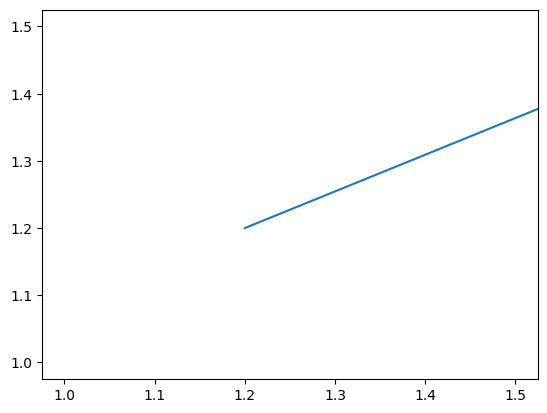

3


In [58]:
arr = np.array([0.0,0.0,1.0])
np.where(arr==0)[0]
fig = plt.figure()
ax = fig.add_subplot(111)
# dd = ax.plot(np.array([1,1.5]),np.array([1,1.5]))
dd = ax.plot([1,1.5],[1,1.5])[0]
dd.set_xdata([1.2,4.5])
dd.set_ydata([1.2,3.])
plt.show()
print(len(arr))

/var/folders/vm/7s65vjln52b98463x70b1l_c0000gn/T/ipykernel_3376/1839750979.py:1: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dd[0].set_xdata(2)
/var/folders/vm/7s65vjln52b98463x70b1l_c0000gn/T/ipykernel_3376/1839750979.py:2: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dd[0].set_ydata(2)


In [31]:
plt.show(dd)